In [10]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import LeaveOneOut, KFold, cross_val_predict,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline,make_pipeline
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ConstantKernel as C,DotProduct, RationalQuadratic
from sklearn.neural_network import MLPRegressor
import shap
import warnings
warnings.filterwarnings("ignore")

In [11]:
# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['SimHei'] # 显示中文
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
##Pearson和ANOVA特征计算用，先放着，暂时没用
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression

# --- A. Pearson 相关系数 ---
plt.figure(figsize=(10, 8))
# 计算特征与目标，以及特征之间的相关性
correlation_matrix = df[features + [target]].corr(method='pearson')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Pearson Correlation Matrix")
plt.show()

# --- B. ANOVA (F-test) 特征重要性评分 ---
# f_regression 适用于回归问题，计算每个特征与目标的 F-value
f_scores, p_values = f_regression(X, y)

# 创建结果表
anova_results = pd.DataFrame({
    'Feature': features,
    'F_Score': f_scores,
    'P_Value': p_values
})
# 按 F_Score 降序排列
anova_results = anova_results.sort_values(by='F_Score', ascending=False)

print("\n=== ANOVA (F-test) Feature Importance ===")
print(anova_results)

# 解读：
# F_Score 越高，说明该特征与目标变量的线性依赖关系越强。
# P_Value < 0.05 说明该相关性在统计学上是显著的。

In [21]:
# 初始准备工作
# 1.读取清洗好的数据
file_path = "Final_Features_12.7.csv" 
df = pd.read_csv(file_path)

In [22]:
# 2.定义特征组
# 力学特征
features_mech = [
    'X1_SoftSeg', 'X2_DA_Content', 'X3_HardSeg', 'X4_R_Ratio', 'X5_Crosslink', 
    'DA_strategy', 'cross_class',
    'Polyol_Type', 'Polyol_Mw_Score', 'Soft_Cryst',
    'Iso_Type', 'Hard_Symmetry', 
    'Interact_Cryst_Content', 'Synergy_Feature'
]
# 愈合特征
features_heal = features_mech + ['healing_temperature', 'healing_time']

# 3. 二次清洗
def get_clean_data(target_col, feature_cols, df):
    # 剔除空值
    data = df.dropna(subset=[target_col] + feature_cols).copy()
    X = data[feature_cols].values
    y = data[target_col].values
    return X, y

# 4. 定义评估函数 
def evaluate_model(model, X, y, task_name="Task"):
    # 使用 LOOCV (留一法) 适合小样本
    cv = LeaveOneOut() 
    
    # 预测
    # 注意：对于 SVR/ANN 等对尺度敏感的模型，我们在 Pipeline 里已经封装了 Scaler，
    # 但为了保险，这里建议外部也可以统一 Scale，或者依赖模型内部的 Pipeline
    y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)
    
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    return r2, rmse, y_pred

print("环境设置完毕，特征组已定义。")
print("数据概览 (前5行):")
print(df[features_mech].head())
print(f"\n有效总样本数: {len(df)}")

环境设置完毕，特征组已定义。
数据概览 (前5行):
   X1_SoftSeg  X2_DA_Content  X3_HardSeg  X4_R_Ratio  X5_Crosslink  \
0      0.6651            0.0      0.3349      1.3333        0.0000   
1      0.6353            0.0      0.3647      1.3846        0.0000   
2      0.6082            0.0      0.3918      1.4286        0.0000   
3      0.5592            0.0      0.4408      1.0000        0.0002   
4      0.5389            0.0      0.4249      1.0000        0.0002   

   DA_strategy  cross_class  Polyol_Type  Polyol_Mw_Score  Soft_Cryst  \
0            0            1          0.0              0.0         0.5   
1            0            1          0.0              0.0         0.5   
2            0            1          0.0              0.0         0.5   
3            0            1          0.0              0.0         0.5   
4            0            1          0.0              0.0         0.5   

   Iso_Type  Hard_Symmetry  Interact_Cryst_Content  Synergy_Feature  
0       2.0              0                 

开始进行GPR模型运算 (样本数: 50)...
=== GPR结果 (healing_eff) ===
R2 Score: 0.1191
RMSE: 0.1788


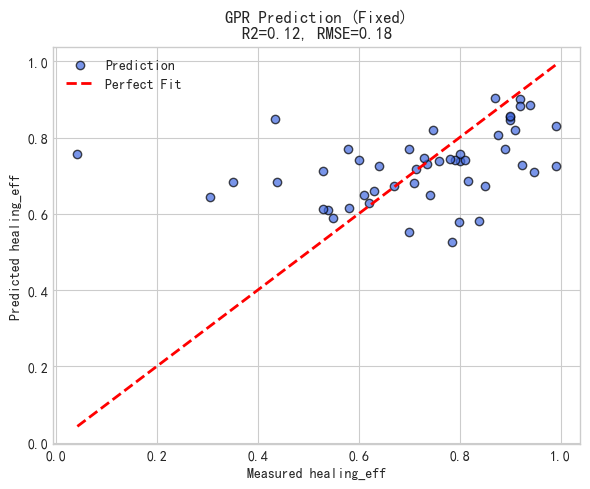

In [23]:
# GPR
from sklearn.compose import TransformedTargetRegressor

target_col = 'healing_eff'
features = features_mech
X, y = get_clean_data(target_col, features, df)

print(f"开始进行GPR模型运算 (样本数: {len(y)})...")

# 定义核函数
kernel = C(1.0, (1e-5, 1e5)) * \
         Matern(length_scale=1.0, length_scale_bounds=(1e-3, 1e4), nu=2.5) + \
         WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5, 1e1))

#  定义模型 
gpr_model = make_pipeline(
    StandardScaler(),  # 标准化特征 X
    GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=10,  # 重启10次防止局部最优
        random_state=42,
        normalize_y=True       
    )
)

# 模型性能评估
r2, rmse, y_pred_gpr = evaluate_model(gpr_model, X, y, task_name="GPR (Fixed)")

print(f"=== GPR结果 ({target_col}) ===")
print(f"R2 Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

# 预测图绘制
plt.figure(figsize=(6, 5))
plt.scatter(y, y_pred_gpr, alpha=0.7, c='royalblue', edgecolors='k', label='Prediction')
# 拟合直线
min_val, max_val = min(y.min(), y_pred_gpr.min()), max(y.max(), y_pred_gpr.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Fit')

plt.xlabel(f'Measured {target_col}')
plt.ylabel(f'Predicted {target_col}')
plt.title(f'GPR Prediction (Fixed)\nR2={r2:.2f}, RMSE={rmse:.2f}')
plt.legend()
plt.tight_layout()
plt.show()

In [1]:
#GPR
# 计算特征重要性
# 全量拟合一次模型
gpr_model.fit(X, y)

print("\n正在计算排列重要性 (Permutation Importance)...")
# n_repeats、random_state参数设置保证结果可复现
r = permutation_importance(gpr_model, X, y, n_repeats=30, random_state=42, scoring='r2')

# 获取重要性均值
importances = r.importances_mean
# 排序
indices = np.argsort(importances)[::-1]

print("\n[特征重要性排行 (基于 R2 损失)]")
print("(数值代表：如果没有这个特征，R2 会下降多少)")
top_features = []
for i in range(len(features)):
    idx = indices[i]
    # 只显示正贡献的特征
    if importances[idx] > 0:
        print(f"{i+1}. {features[idx]}: {importances[idx]:.4f}")
        top_features.append((features[idx], importances[idx]))

# 特征图绘制
plt.figure(figsize=(10, 6))
plt.title(f"Feature Importance (Permutation) - Target: {target_col}", fontsize=14)
plt.bar(range(len(top_features)), [val for name, val in top_features], color='cornflowerblue', align="center")
plt.xticks(range(len(top_features)), [name for name, val in top_features], rotation=45, ha='right')
plt.ylabel("Decrease in R2 Score")
plt.tight_layout()
plt.show()

NameError: name 'gpr_model' is not defined

In [ ]:
# Random Forest
target_col = 'healing_eff'  
features = features_mech          
X, y = get_clean_data(target_col, features, df)

# 获取数据
X, y = get_clean_data(target_col, features, df)

# 定义模型
rf_model = RandomForestRegressor(
    n_estimators=350,      # 树的数量
    max_depth=10,        # 树的最大深度
    min_samples_split=5,   # 节点分裂所需的最小样本数
    random_state=42,
    n_jobs=-1
)

# 评估
print("正在进行 LOOCV 交叉验证评估精度...")
y_pred = cross_val_predict(rf_model, X, y, cv=LeaveOneOut(), n_jobs=-1)
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"=== Random Forest 结果 ({target_col}) ===")
print(f"R2 Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

# 全量拟合一次模型
print("\n正在全量拟合模型 (为 SHAP 做准备)...")
rf_model.fit(X, y)

# 绘图
plt.figure(figsize=(5, 5))
plt.scatter(y, y_pred, color='teal', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title(f"RF Prediction (R2={r2:.2f})")
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.show()

In [ ]:
# Random Forest
# --- SHAP 分析 ---
# 对于随机森林，SHAP 计算量比 XGBoost 大
print("正在计算 Random Forest 的 SHAP 值...")
explainer = shap.TreeExplainer(rf_model)
# 如果报错，尝试: shap_values = explainer.shap_values(X)
shap_values = explainer(X)

# 绘图
plt.figure(figsize=(10, 6))
plt.title(f"RF - SHAP Summary for {target_col}")
# 处理 shap_values 格式兼容性 
if isinstance(shap_values, list): # 针对分类任务或旧版
    sv = shap_values[1]
else:
    sv = shap_values

shap.summary_plot(sv, X, feature_names=features)

In [ ]:
# XGBoost
target_col = 'tensile_strength' 
features = features_mech
X, y = get_clean_data(target_col, features, df)

# --- 2. 定义参数字典 (注意：这里是字典 dict，不是模型对象) ---
xgb_params = {
    'n_estimators': 100,
    'learning_rate': 0.02,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1
    # 'device': 'cuda' # 如果有显卡，取消注释这一行
}

# --- 3. 手写 LOOCV 循环 (同时收集 预测值 和 SHAP值) ---
print(f"正在进行严谨的 CV-SHAP 计算 (样本数: {len(y)})...")

loo = LeaveOneOut()
y_pred_cv = np.zeros(len(y)) # 存放预测结果
shap_values_cv = []          # 存放 SHAP 结果
indices_cv = []              # 记录顺序，防止乱序

# 遍历每一个样本
for train_idx, test_idx in loo.split(X):
    # A. 切分数据
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # B. 训练模型 (只用训练集!)
    model = XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)
    
    # C. 预测 (为了算 R2)
    pred = model.predict(X_test)
    y_pred_cv[test_idx] = pred
    
    # D. 计算 SHAP (为了解释)
    # 注意：我们要解释的是模型对“测试集”的判断逻辑
    explainer = shap.TreeExplainer(model)
    shap_val = explainer.shap_values(X_test)
    
    # E. 收集结果
    shap_values_cv.append(shap_val[0]) # LOOCV每次只有1个样本
    indices_cv.append(test_idx[0])

# 将 SHAP list 转为矩阵
shap_values_cv = np.array(shap_values_cv)

# --- 4. 结果汇总 ---
# 真实的 R2 (基于 LOOCV)
r2_real = r2_score(y, y_pred_cv)
rmse_real = np.sqrt(mean_squared_error(y, y_pred_cv))

print(f"\n=== 最终结果 (基于 LOOCV) ===")
print(f"✅ 真实泛化 R2: {r2_real:.4f}")
print(f"✅ 真实泛化 RMSE: {rmse_real:.4f}")

# 绘图
plt.figure(figsize=(6, 5))
plt.scatter(y, y_pred_cv, color='purple', alpha=0.6, label='CV Prediction')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect Fit')
plt.title(f"Real XGBoost Performance\nR2={r2_real:.2f}")
plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.legend()
plt.show()

In [ ]:

# --- 5. 真实的 SHAP 绘图 ---
print("\n生成 CV-SHAP 图 (解释的是模型如何预测未知样本)...")

# 图1: 蜜蜂图
plt.figure(figsize=(10, 6))
plt.title(f"CV-SHAP Summary (Generalization Logic)", fontsize=16)
shap.summary_plot(shap_values_cv, X, feature_names=features, show=False)
plt.tight_layout()
plt.show()

# 图2: 依赖图 (看新特征)
if 'Iso_Type' in features:
    shap.dependence_plot('Iso_Type', shap_values_cv, X, feature_names=features, interaction_index=None)

In [ ]:
# SVR
target_col = 'tensile_strength'
features = features_mech
X, y = get_clean_data(target_col, features, df)

# --- 2. 定义参数网格 ---
# SVR 的三个核心参数：
# C: 惩罚系数。越大越不容忍误差（容易过拟合），越小越平滑（容易欠拟合）。
# gamma: 核函数宽度。越大越关注局部细节，越小越关注全局趋势。
# epsilon: 对误差的容忍带宽度。
param_grid = {
    'svr__C': [1, 10, 50, 100, 500, 1000], 
    'svr__gamma': ['scale', 0.001, 0.01, 0.1, 0.5, 1.0],
    'svr__epsilon': [0.01, 0.1, 0.5]
}

# --- 3. 网格搜索 (GridSearchCV) ---
# 建立 Pipeline
pipe = make_pipeline(StandardScaler(), SVR(kernel='rbf'))

# 使用 LOOCV 进行搜索 (保证和小样本验证逻辑一致)
# scoring='neg_mean_squared_error' 表示寻找 MSE 最小的组合
grid_search = GridSearchCV(
    pipe, 
    param_grid, 
    cv=LeaveOneOut(), # 如果觉得太慢，可以改为 cv=5
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y)

# 获取最佳模型
best_svr = grid_search.best_estimator_
best_params = grid_search.best_params_

print("\n[最佳参数组合]")
print(best_params)

# --- 4. 使用最佳参数进行最终预测 (LOOCV) ---
# 为了严谨，我们用在这个最佳参数下重新跑一遍 LOOCV 预测
print("\n正在生成最终预测结果...")
y_pred_svr = cross_val_predict(best_svr, X, y, cv=LeaveOneOut(), n_jobs=-1)

# 计算指标
r2 = r2_score(y, y_pred_svr)
rmse = np.sqrt(mean_squared_error(y, y_pred_svr))

print(f"\n=== SVR (调优后) 结果 ===")
print(f"R2 Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

# --- 5. 绘图: 预测值 vs 真实值 ---
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred_svr, c='darkorange', alpha=0.7, edgecolors='k', s=60, label='SVR Prediction')
# 画对角线
min_val, max_val = min(y.min(), y_pred_svr.min()), max(y.max(), y_pred_svr.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect Fit')

plt.title(f"Optimized SVR Prediction\nR2={r2:.2f}, RMSE={rmse:.2f}")
plt.xlabel("Measured Tensile Strength")
plt.ylabel("Predicted Tensile Strength")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
# --- 6. 计算特征重要性 (Permutation Importance) ---
# 必须使用拟合好的最佳模型
best_svr.fit(X, y)

print("正在计算 SVR 的特征重要性 (Permutation)...")
# n_repeats=30 意味着每个特征打乱30次来测试稳定性
result = permutation_importance(best_svr, X, y, n_repeats=30, random_state=42, scoring='r2')

# 整理结果
perm_sorted_idx = result.importances_mean.argsort()[::-1]

print("\n[SVR 特征重要性排行 (基于 R2 损失)]")
top_features = []
for i in perm_sorted_idx:
    name = features[i]
    score = result.importances_mean[i]
    # 只显示正贡献的特征
    if score > 0:
        print(f"{name}: {score:.4f}")
        top_features.append((name, score))

# --- 7. 绘图: 特征重要性柱状图 ---
features_plot = [x[0] for x in top_features]
scores_plot = [x[1] for x in top_features]

plt.figure(figsize=(10, 6))
plt.bar(range(len(features_plot)), scores_plot, color='darkorange', alpha=0.7)
plt.xticks(range(len(features_plot)), features_plot, rotation=45, ha='right')
plt.title("Feature Importance for SVR (Permutation)", fontsize=14)
plt.ylabel("Decrease in R2 Score")
plt.tight_layout()
plt.show()

In [ ]:
# KRR
target_col = 'tensile_strength'
features = features_mech
X, y = get_clean_data(target_col, features, df)

# --- 2. 定义参数网格 ---
# alpha: 正则化项。类似于 SVR 的 1/C。
# gamma: RBF 核的宽度。
param_grid = {
    'kernelridge__alpha': [1e-3, 1e-2, 0.04, 0.05, 0.1, 1, 10],   # 正则化强度
    'kernelridge__gamma': [1e-3, 1e-2, 0.1, 0.5, 1, 5] # 核函数敏感度
}

# --- 3. 网格搜索 (GridSearchCV) ---
pipe = make_pipeline(StandardScaler(), KernelRidge(kernel='rbf'))

grid_search = GridSearchCV(
    pipe, 
    param_grid, 
    cv=LeaveOneOut(), # 保持一致，使用留一法
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y)

# 获取最佳模型
best_krr = grid_search.best_estimator_
best_params = grid_search.best_params_

print("\n[最佳参数组合]")
print(best_params)

# --- 4. 使用最佳参数进行最终预测 (LOOCV) ---
# 再次跑一遍 LOOCV 以获取真实的泛化分数
print("\n正在生成最终预测结果...")
y_pred_krr = cross_val_predict(best_krr, X, y, cv=LeaveOneOut(), n_jobs=-1)

# 计算指标
r2 = r2_score(y, y_pred_krr)
rmse = np.sqrt(mean_squared_error(y, y_pred_krr))

print(f"\n=== KRR (调优后) 结果 ===")
print(f"R2 Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

# --- 5. 绘图: 预测值 vs 真实值 ---
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred_krr, c='forestgreen', alpha=0.7, edgecolors='k', s=60, label='KRR Prediction')
# 画对角线
min_val, max_val = min(y.min(), y_pred_krr.min()), max(y.max(), y_pred_krr.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect Fit')

plt.title(f"Optimized KRR Prediction\nR2={r2:.2f}, RMSE={rmse:.2f}")
plt.xlabel("Measured Tensile Strength")
plt.ylabel("Predicted Tensile Strength")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
# --- 6. 计算特征重要性 (Permutation Importance) ---
# 必须先全量拟合一次最佳模型
best_krr.fit(X, y)

print("正在计算 KRR 的特征重要性 (Permutation)...")
result = permutation_importance(best_krr, X, y, n_repeats=30, random_state=42, scoring='r2')

# 整理结果
perm_sorted_idx = result.importances_mean.argsort()[::-1]

print("\n[KRR 特征重要性排行 (基于 R2 损失)]")
top_features_krr = []
for i in perm_sorted_idx:
    name = features[i]
    score = result.importances_mean[i]
    # 只显示正贡献的特征
    if score > 0:
        print(f"{name}: {score:.4f}")
        top_features_krr.append((name, score))

# --- 7. 绘图: 特征重要性柱状图 ---
features_plot = [x[0] for x in top_features_krr]
scores_plot = [x[1] for x in top_features_krr]

plt.figure(figsize=(10, 6))
plt.bar(range(len(features_plot)), scores_plot, color='forestgreen', alpha=0.7)
plt.xticks(range(len(features_plot)), features_plot, rotation=45, ha='right')
plt.title("Feature Importance for KRR (Permutation)", fontsize=14)
plt.ylabel("Decrease in R2 Score")
plt.tight_layout()
plt.show()

In [ ]:
# ANN
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

target_col = 'tensile_strength'
features = features_mech
X, y = get_clean_data(target_col, features, df)

# --- 2. 定义参数网格 ---
# 这是一个针对小样本优化的搜索空间
param_grid = {
    'mlpregressor__hidden_layer_sizes': [(32,), (64,), (32, 16), (64, 32)], # 尝试更简单的结构
    'mlpregressor__activation': ['relu', 'tanh'],  # tanh 对回归任务有时更平滑
    'mlpregressor__solver': ['lbfgs', 'adam'],     # lbfgs 是小样本的关键！
    'mlpregressor__alpha': [0.0001, 0.001, 0.01, 0.1], # 正则化力度
    'mlpregressor__learning_rate_init': [0.001, 0.01]  # 初始学习率
}

# --- 3. 网格搜索 (GridSearchCV) ---
# 定义 Pipeline (必须标准化！)
pipe = make_pipeline(
    StandardScaler(), 
    MLPRegressor(max_iter=5000, random_state=42) # 增加迭代次数防止不收敛
)

grid_search = GridSearchCV(
    pipe, 
    param_grid, 
    cv=LeaveOneOut(), # 保持一致，使用留一法
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y)

# 获取最佳模型
best_ann = grid_search.best_estimator_
best_params = grid_search.best_params_

print("\n[最佳参数组合]")
print(best_params)

# --- 4. 使用最佳参数进行最终预测 (LOOCV) ---
print("\n正在生成最终预测结果...")
y_pred_ann = cross_val_predict(best_ann, X, y, cv=LeaveOneOut(), n_jobs=-1)

# 计算指标
r2 = r2_score(y, y_pred_ann)
rmse = np.sqrt(mean_squared_error(y, y_pred_ann))

print(f"\n=== ANN (调优后) 结果 ===")
print(f"R2 Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

# --- 5. 绘图: 预测值 vs 真实值 ---
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred_ann, c='mediumvioletred', alpha=0.7, edgecolors='k', s=60, label='ANN Prediction')
# 画对角线
min_val, max_val = min(y.min(), y_pred_ann.min()), max(y.max(), y_pred_ann.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect Fit')

plt.title(f"Optimized ANN Prediction\nR2={r2:.2f}, RMSE={rmse:.2f}")
plt.xlabel("Measured Tensile Strength")
plt.ylabel("Predicted Tensile Strength")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
# --- 6. 计算特征重要性 (Permutation Importance) ---
# 必须先全量拟合一次最佳模型
best_ann.fit(X, y)

print("正在计算 ANN 的特征重要性 (Permutation)...")
result = permutation_importance(best_ann, X, y, n_repeats=30, random_state=42, scoring='r2')

# 整理结果
perm_sorted_idx = result.importances_mean.argsort()[::-1]

print("\n[ANN 特征重要性排行 (基于 R2 损失)]")
top_features_ann = []
for i in perm_sorted_idx:
    name = features[i]
    score = result.importances_mean[i]
    if score > 0: # 只显示正贡献
        print(f"{name}: {score:.4f}")
        top_features_ann.append((name, score))

# --- 7. 绘图: 特征重要性柱状图 ---
features_plot = [x[0] for x in top_features_ann]
scores_plot = [x[1] for x in top_features_ann]

plt.figure(figsize=(10, 6))
plt.bar(range(len(features_plot)), scores_plot, color='mediumvioletred', alpha=0.7)
plt.xticks(range(len(features_plot)), features_plot, rotation=45, ha='right')
plt.title("Feature Importance for ANN (Permutation)", fontsize=14)
plt.ylabel("Decrease in R2 Score")
plt.tight_layout()
plt.show()

In [2]:
# 多模型能力横向对比
models_dict = {
    "Random Forest": RandomForestRegressor(n_estimators=500, max_depth=30,min_samples_split=5,   random_state=42,n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=100,learning_rate=0.02,max_depth=5,subsample=0.7,colsample_bytree=0.8,random_state=42,n_jobs=-1),
    "SVR": make_pipeline(StandardScaler(), SVR(C=500, gamma=1.0,epsilon=0.1)),
    "GPR": make_pipeline(StandardScaler(),GaussianProcessRegressor(kernel=1.0*Matern(length_scale=1.0, length_scale_bounds=(1e-2,1e2), nu=2.5)+ WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5,1e1)),
        n_restarts_optimizer=10,
        random_state=42,
        normalize_y=True)),
    "ANN (MLP)": make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(64,),activation='tanh',learning_rate_init=0.001, max_iter=2000, alpha=0.01, random_state=42, solver='lbfgs',)),
    "KRR": make_pipeline(StandardScaler(), KernelRidge(kernel='rbf', gamma=0.1,alpha=0.04))
}

# 设置要预测的目标
current_target = 'healing_eff' 
# 自动选择特征集
current_features = features_heal if current_target == 'healing_eff' else features_mech

# 获取数据
X, y = get_clean_data(current_target, current_features, df)
print(f"正在对比所有模型，预测目标: {current_target} (样本数: {len(y)})...")

results = []

for name, model in models_dict.items():
    r2, rmse, _ = evaluate_model(model, X, y)
    results.append({"Model": name, "R2": r2, "RMSE": rmse})
    print(f" -> {name} 完成: R2={r2:.3f}")

# ---------- 将结果转为 DataFrame 并按 R2 排序 ----------
res_df = pd.DataFrame(results).sort_values(by="R2", ascending=False).reset_index(drop=True)

# 显示排序后的表格（可选）
print("\n排序后的模型性能：")
print(res_df)

# --- 绘图部分（保证柱状图与折线顺序一致） ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# 用数值位置作为 x 轴（0..n-1）
x_pos = np.arange(len(res_df))

# 柱状图：R2
bars = ax1.bar(x_pos, res_df['R2'], alpha=0.85, width=0.6)
ax1.set_xlabel("Model", fontsize=12)
ax1.set_ylabel("R2 Score (Higher is Better)", fontsize=12)
ax1.set_ylim(0, 1.05)  # R2 一般在 0-1 之间（可根据实际调整）
ax1.set_xticks(x_pos)
ax1.set_xticklabels(res_df['Model'], rotation=30, ha='right', fontsize=11)

# 在每个柱子上加数值注释
for i, r2 in enumerate(res_df['R2']):
    ax1.text(i, r2 + 0.02, f"{r2:.2f}", ha='center', va='bottom', fontweight='bold')

# 右侧 y 轴绘制 RMSE 折线（与柱子位置一一对应）
ax2 = ax1.twinx()
ax2.plot(x_pos, res_df['RMSE'], marker='o', linewidth=2, linestyle='-', label='RMSE')
ax2.set_ylabel("RMSE (Lower is Better)", fontsize=12)
# 可根据 RMSE 范围微调 ylimits，例如：
rmse_min, rmse_max = res_df['RMSE'].min(), res_df['RMSE'].max()
pad = (rmse_max - rmse_min) * 0.15 if rmse_max != rmse_min else 1.0
ax2.set_ylim(rmse_min - pad, rmse_max + pad)

# 在折线上每个点标注 RMSE 值
for i, rmse in enumerate(res_df['RMSE']):
    ax2.text(i, rmse + (pad * 0.03), f"{rmse:.2f}", ha='center', va='bottom', color='red')

# 标题与样式
plt.title(f"Model Comparison for {current_target}", fontsize=14)
ax1.grid(False)
ax2.grid(False)
fig.tight_layout()
plt.show()

# 打印详细排名表（已按 R2 排序）
print("\n详细排名：")
print(res_df)

NameError: name 'RandomForestRegressor' is not defined